# Notebook description

This notebook attempts to recreate the key results from [Quantum Optimal Control for Mixed State Squeezing in Cavity Optomechanics](https://arxiv.org/pdf/1807.04718.pdf) by Basilewitsch et al. The paper is the first to use Krotov's method, a method from optimal control theory, to optimize control sequences in a cavity ooptomecchanics setting. In particular, the authors design a two-tone optical pulse sequence that speed up optomechanical squeezing of a mechanical object's motion when it's placed in an optical cavity. 

We use the `krotov` package, which is a well-documented OCT package built upon the open system quantum simulation package `qutip` For details on how to use `qutip` to simulate dynamics between tensor states and extract relevant metrics, consult `test_qutip_examples.ipynb`. For an in depth tutorial on how to use the th `krotov` package, consult `test_krotov.ipynb`.

# The theory

We describe the cavity and mechanical oscillator with annihilation operators $d$ and $b$. In the weak-coupling limit,  the optomechanical system is described by the linearized Hamiltonian 

\\[
 H_{om} = -d^\dagger \big[G_+(t) b^\dagger + G_-(t)b\big] + \text{h.c.}
\\]

where we take $\hbar = 1$. Here, $G_+(t)$ is the coupling rate which drives two-mode-squeezng between the cavity and mechanical fields, and $G_-(t)$ is the couplng rate which drives coherent (beam-splitter) exchange of excitations between the cavity and mechanical fields. In practice, these are known as the blue- and red-detuned pumps, respectively, in referecnce to how they're detuned from the cavity frequency. The system is subject to 3 decay channels, whose decay operators are given by

$$
\begin{align}
    L_1 &= \sqrt{\kappa} d \\
    L_2 &= \sqrt{\Gamma_m (n_{th}+1)} b \\
    L_3 &= \sqrt{\Gamma_m n_{th}} b^\dagger
\end{align}
$$

Here, $\kappa$ is the cavity decay rate and $\Gamma_m$ is the mechanical decay rate, both in angular frequency units. $n_{th}$ is the mean phonon occupation of the mechanic's thermal environment. The first operator decribes optical energy leaking out of the cavity, while the second and third describe thermal energy leaking out of and into the mechanical resonator, respectively. Keeping $G_+(t)$ and $G_-(t)$ constant in time will result in the creation of a squeezed thermal state, provided that $G_-(t) > G_+(t)$. The paper proposes a method to speed up this approach by including time-dependence in these coupling rates.

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import krotov
from krotov.second_order import _overlap # state overlap function. Hilbert-Schmidt overlap for density matrices.

# Initialize parameters

We initialize the simulation parameters according to the paper. The Hilbert space dimensions where chosen to prevent wrap-around effects during the simulation. Coupling rates are values typically found in state-of-the-art membrane-in-the-middle optomechanical systems.

In [132]:
# occupancies
Nd = 4 # Hilbert dimension of cavity field
Nb = 30 # Hilbert dimension of mechanical field
nth = 2 # thermal phonon occpancy of mechanical bath

# coupling rates
Gamma_m = 2 * np.pi * 3 # mechanical linewidth, angular freq units
kappa = 2*np.pi* 450000 # cavity linewidth, angular freq units

cooperativity = 100 #optomechanical cooperativity
ratio = 0.7         # ratio of blue pump coupling to red pump coupling
Gminus0 = np.sqrt(cooperativity * Gamma_m * kappa /4) #initial cavity-enhanced coupling for red pump, angular freq units
Gplus0 = ratio * Gminus0     #initial cavity-enhanced coupling for blue pump, angular freq units

# Initialize the Liouvillian

Instead of inputing decay operators directly into our simulations, we define a Liouvillian object \mathcal{L} that governs the evolution of our joint mixed state according to

\\[
    \dot{\rho}(t) = \mathcal{L} \rho(t)
\\]
. We must include the tme-dependent pump rates. Further details on constructing this object can be found in `test_krotov.ipynb`.

In [134]:
def Liouvillian(Nd = 4, Nb = 40, nth = 0, Gamma_m = 1, kappa = 1e6, Gminus0 = 1e4, Gplus0 = 1e3):
    '''
    Defines the Liovillian qutip object which will govern time evolution of the optomechanical.
    
    Args:
        Nd: Hilbert dimension of cavity field
        Nb: Hilbert dimension of mechanical field
        nth: thermal phonon occpancy of mechanical bath
        Gamma_m: mechanical linewidth, angular freq units
        kappa: cavity linewidth, angular freq units
        Gminus0: initial cavity-enhanced coupling for red pump, angular freq units
        Gplus0: initial cavity-enhanced coupling for blue pump, angular freq units
        
    Returns:
        Liouvillian object
    '''
    
    # define red and blue coupling coefficients
    eps_minus = lambda t, args: Gminus0
    eps_plus = lambda t, args: Gplus0
    
    # single-sided beam-splitter and two-mode squeezing terms
    Hbs1 = qt.tensor(-qt.create(Nd), qt.destroy(Nb)) # BS: cavity excitation term
    Hbs2 = Hbs1.trans()                              # BS: cavity emission term
    Htms1 = qt.tensor(-qt.create(Nd), qt.create(Nb)) # TMS: cavity excitation term
    Htms2 = Htms1.trans()                              # BS: cavity emission term
    
    # turn BS and TMS terms into Liouvillian objects
    Lbs = qt.liouvillian(Hbs1 + Hbs2)
    Ltms = qt.liouvillian(Htms1 + Htms2)
    
    # define decay operators
    H1 = qt.tensor(np.sqrt(kappa)*qt.destroy(Nd), qt.identity(Nb)) # cavity decay
    H2 = qt.tensor(qt.identity(Nd), np.sqrt(Gamma_m*(nth+ 1))*qt.destroy(Nb)) # phonon emission into bath
    H3 = qt.tensor(qt.identity(Nd), np.sqrt(Gamma_m*nth)*qt.create(Nb)) # phonon absorption into bath
    
    # convert decay operators to Liovillian objects
    L1 = qt.lindblad_dissipator(H1) 
    L2 = qt.lindblad_dissipator(H2) 
    L3 = qt.lindblad_dissipator(H3) 
     
    return  [[Lbs, eps_minus],[Ltms, eps_plus], L1, L2, L3]

L = Liouvillian(Nd =Nd, Nb=Nb, nth=nth, Gamma_m=Gamma_m, kappa=kappa, Gminus0=Gminus0, Gplus0=Gplus0)

# Constant-amplitude simulation

We simulate the squeezing under constamt amplitde drives. Owing to low thermal occupancy st room temperature, the cavity starts in a vacuum state. The mechanical resonator starts in thermal equilibium with its environment. We simulate the dynamics of the state under our Liouvillian, and store the expectation values of the quadrature square projectors and mechanical occupany. Details on simulation implementation can be found in `test_qutip_examples.ipynb`. The total simulation takes about 1 minute to run with 1000 points.

In [ ]:
# initial state
rho_init = qt.tensor(qt.fock_dm(Nd, 0), qt.thermal_dm(Nb, nth))

# define X1^2 projector
X1m = (qt.create(Nb) + qt.destroy(Nb))/np.sqrt(2)
proj0 = qt.tensor(qt.identity(Nd), X1m**2)

# define X2^2 projector
X2m = (qt.create(Nb) - qt.destroy(Nb))/np.sqrt(2)/1j
proj1 = qt.tensor(qt.identity(Nd), X2m**2)

# define phonon number projector
proj2 = qt.tensor(qt.identity(Nd), qt.create(Nb)*qt.destroy(Nb))

# define time array
tlist = np.linspace(0, 15e-3, 1000) # time in seconds

# simulate trajectory
guess_dynamics = qt.mesolve(L, rho0 = rho_init, tlist=tlist, e_ops=[proj0, proj1, proj2])

## Plotting the squeezing

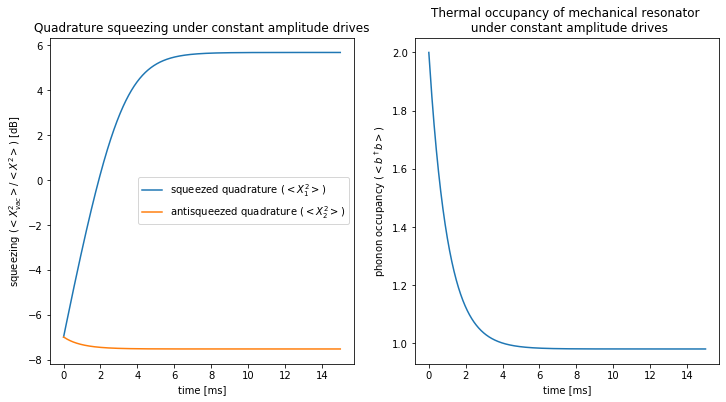

The first quadrature is squeezed by 5.68075 dB
The second quadrature is antisqueezed by 7.52225 dB


In [189]:
# Define function to assist with plotting
def quad2_dB(quad2, Nb):
    '''
    Converts the expectation value of a squared quadrature opertr to dB units of squeezing, 
    compared to vacuum levels.
    
    Args:
        quad2: array of expectation values of square quadrature operators
        Nb: size of fmechanical 
        
    Returns:
        quad2 array converted to dB of squeezing
    '''
    # define vacuum state
    vac = qt.fock_dm(Nb, 0)
    
    # expectation value in vacuum
    expec_vac = (vac*X1m**2).tr()
    
    # convert to dB
    dB_val = 10*np.log10(np.divide(expec_vac,quad2))
    
    return dB_val


## plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))

# plot squeezed and antisqueezed quadratures
ax1.plot(
    guess_dynamics.times * 1000,
    quad2_dB(guess_dynamics.expect[0], Nb),
    label=r'squeezed quadrature ($<X_1^2>$)',
)
ax1.plot(
    guess_dynamics.times * 1000,
    quad2_dB(guess_dynamics.expect[1], Nb),
    label=r'antisqueezed quadrature ($<X_2^2>$)',
)
ax1.legend()
ax1.set_xlabel('time [ms]')
ax1.set_ylabel(r'squeezing ($<X_{vac}^2>/<X^2>$) [dB]')
ax1.set_title('Quadrature squeezing under constant amplitude drives')


# plot mechanical phonon number
ax2.plot(
    guess_dynamics.times * 1000,
    np.array(guess_dynamics.expect[2])
)
ax2.set_xlabel('time [ms]')
ax2.set_ylabel(r'phonon occupancy ($<b^\dagger b>$)')
ax2.set_title('Thermal occupancy of mechanical resonator \n under constant amplitude drives')


plt.show()

# print final quadtraure squeezing value

print('The first quadrature is squeezed by %g dB' % quad2_dB(guess_dynamics.expect[0], Nb)[-1])
print('The second quadrature is antisqueezed by %g dB' % -quad2_dB(guess_dynamics.expect[1], Nb)[-1])

# Define optimization objective 

We re-run the above simulation and store the states at each time. We choose the final state as our target state, which is very close to the system's steady state. We then populate a `krotov.Objective` object. Details on this object can be found in `test_krotov.ipynb`.

In [142]:
# re-run simulation and store states instead of expectation values
guess_dynamics_states = qt.mesolve(L, rho0 = rho_init, tlist=tlist)

#define final state and objective function
rho_final = guess_dynamics_states.states[-1]
objectives = [krotov.Objective(initial_state = rho_init, target = rho_final, H=L)]

## Plotting the target states

We use the `qutip.wigner` function to plot Wigner functions of the initial and final states. We take a partial trace over the cavity so that we're just plotting the mechanical state.

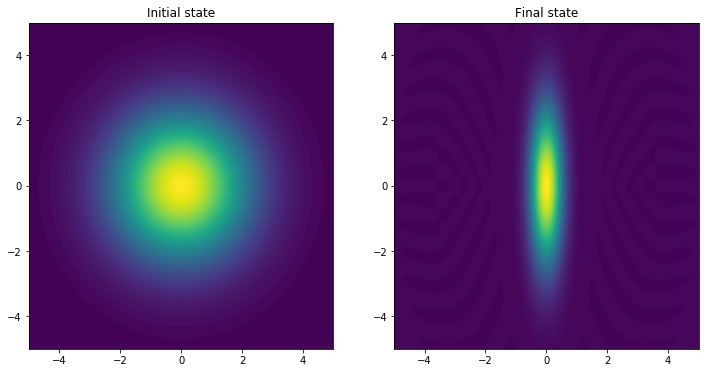

In [146]:
# define x limits
xvec = np.linspace(-5,5,200)

# store initial and final mechanical state in a contour plotting object
W_init = qt.wigner(rho_init.ptrace(1), xvec, xvec)
W_final = qt.wigner(rho_final.ptrace(1), xvec, xvec)

# plot the states
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
ax1.contourf(xvec, xvec, W_init, 100)
ax1.set_title("Initial state")
ax2.contourf(xvec, xvec, W_final, 100)
ax2.set_title("Final state")
plt.show()

# Define Krotov step sizes

The step sizes of the Krotov updates are determined by $\lambda_a$, which sets the global step size and $S(t) \in (0,1]$, which scales the step size at each point to smooth out the control sequences. These parameters are stored in a `krotov.pulse_options` dictionary, which is detailed more in `test_krotov.ipynb`.

For this particular simulation, we found that setting $\lambda_a = 2 \times 10^{-7}$ for both driving amplitudes led to the quickest convergence of the alghrithm among all parameters tested. Increasing $\lambda_a$ by even a factor of 4 caused the convergene to slow down significantly, and decreasing it to $2 \times 10^{-7}$ caused instabilities in the pulse sequence. We note that these $\lambda_a$ values are significantly smaller than the order-unity ones used in `test_krotov.ipynb`. We hypothesize that this has something to do with the significantly larger Hilbert space used, but it's still unclear why.

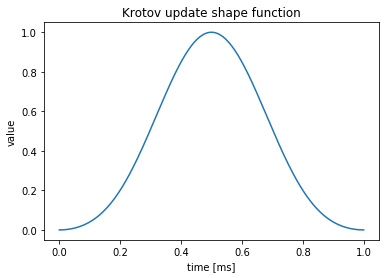

In [154]:
# define shape function
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=1e-3, t_rise=5e-4, t_fall=5e-4, func='blackman'
    )

# plot the shape function
tlist2 = np.linspace(0,1e-3,1000) # new time list for optimization, in seconds
shape = np.zeros_like(tlist2)
for ii in range(len(tlist2)):
    shape[ii] = S(tlist2[ii])
plt.figure()
plt.plot(tlist2*1000, shape)
plt.xlabel('time [ms]')
plt.ylabel('value')
plt.title('Krotov update shape function')
plt.show()

# define global update step
lambda_set = 2e-7 #starting with 1e-6 is good

# define pulse_options dictionary
pulse_options = {
    L[0][1]: dict(lambda_a=lambda_set, update_shape=S),
    L[1][1]: dict(lambda_a=lambda_set, update_shape=S)
}

# Optimizing the pulse sequence

We run the optimization algorithm now. Details on all the arguments can be found in `test_krotov.ipynb`. We use the Hilbert-Schmidt distance as our $J_T$ in our cost function, since this was what the paper showed had the best convergence. This functional is already built into the `krotov` package as `functionals.J_T_hs()`. The corresponding chi-constructor (used in the backward propagation step) is defined by `krotov.functionals.chis_hs()`.

We run the algorithm or 60 iterations, since this should be sufficient to reach a distance below $10^{-9}$, which was the lowest that was reached in the paper.

In [119]:
# perform optimization
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist2,
    propagator=krotov.propagators.DensityMatrixODEPropagator(),
    chi_constructor=krotov.functionals.chis_hs,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_hs),
#     check_convergence=krotov.convergence.Or(
#         krotov.convergence.value_below('1e-3', name='J_T'),
#        krotov.convergence.check_monotonic_error,
#     )
#     info_hook=krotov.info_hooks.chain(
#         krotov.info_hooks.print_debug_information
#     ),
    iter_stop = 60
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.60e-01    0.00e+00   1.60e-01        n/a        n/a    12
1     7.62e-02    2.85e+05   2.85e+05  -8.41e-02   2.85e+05    31 *
2     5.03e-02    5.28e+04   5.28e+04  -2.59e-02   5.28e+04    31 *
3     3.19e-02    3.78e+04   3.78e+04  -1.84e-02   3.78e+04    31 *
4     1.99e-02    2.53e+04   2.53e+04  -1.20e-02   2.53e+04    31 *
5     1.24e-02    1.60e+04   1.60e+04  -7.46e-03   1.60e+04    31 *
6     7.88e-03    9.82e+03   9.82e+03  -4.53e-03   9.82e+03    31 *
7     5.11e-03    6.06e+03   6.06e+03  -2.77e-03   6.06e+03    32 *
8     3.38e-03    3.80e+03   3.80e+03  -1.73e-03   3.80e+03    31 *
9     2.28e-03    2.43e+03   2.43e+03  -1.10e-03   2.43e+03    34 *
10    1.56e-03    1.59e+03   1.59e+03  -7.17e-04   1.59e+03    31 *
11    1.09e-03    1.05e+03   1.05e+03  -4.76e-04   1.05e+03    34 *
12    7.64e-04    7.14e+02   7.14e+02  -3.22e-04   7.14e+02    34 *
13    5.43e-04    4.90e+02   4.90e+02  -2.21e-04   4

## Plotting the Optimized pulse sequences

We plot the optimized coupling rates against the steady-state.

We also include supplementary plots of the amplitude ratio and difference of squares, for comparison with the paper. Our results agree well, both in qualititative character and in numbers. We see that that cooling by the red pump dominates the first part of the sequence, while squeezing by the blue pump is concentrated in the last part.

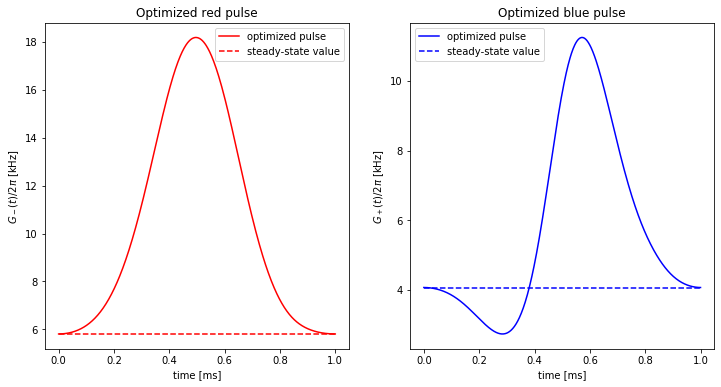

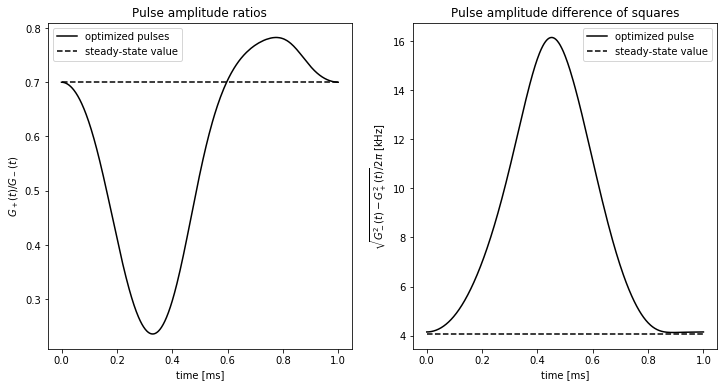

In [182]:
# store red and blue pulses

Gminus = opt_result.optimized_objectives[0].H[0][1] # optimized red pulse array
Gplus = opt_result.optimized_objectives[0].H[1][1] # optimized blue pulse array

## plot pulse sequences
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))

ax1.plot(
    tlist2 * 1000,
    Gminus / 1000 / 2 / np.pi,
    label=r'optimized pulse',
    color = 'red'
)
ax1.plot(
    tlist2 * 1000,
    Gminus0* np.ones_like(tlist2) / 1000 / 2 / np.pi,
    label=r'steady-state value',
    color = 'red',
    linestyle = '--'
)
ax1.legend(loc = 'best')
ax1.set_xlabel('time [ms]')
ax1.set_ylabel(r'$G_-(t)/2\pi$ [kHz]')
ax1.set_title('Optimized red pulse')

ax2.plot(
    tlist2 * 1000,
    Gplus / 1000 / 2 / np.pi,
    label=r'optimized pulse',
    color = 'blue'
)
ax2.plot(
    tlist2 * 1000,
    Gplus0* np.ones_like(tlist2) / 1000 / 2 / np.pi,
    label=r'steady-state value',
    color = 'blue',
    linestyle = '--'
)
ax2.legend(loc = 'best')
ax2.set_xlabel('time [ms]')
ax2.set_ylabel(r'$G_+(t)/2\pi$ [kHz]')
ax2.set_title('Optimized blue pulse')
plt.show()

# supplementary driving plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))

ax1.plot(
    tlist2 * 1000,
    np.divide(Gplus, Gminus),
    label=r'optimized pulses',
    color = 'black'
)
ax1.plot(
    tlist2 * 1000,
    Gplus0/Gminus0 * np.ones_like(tlist2),
    label=r'steady-state value',
    color = 'black',
    linestyle = '--'
)
ax1.legend(loc = 'best')
ax1.set_xlabel('time [ms]')
ax1.set_ylabel(r'$G_+(t)/G_-(t)$')
ax1.set_title('Pulse amplitude ratios')

ax2.plot(
    tlist2 * 1000,
    np.sqrt(Gminus**2 - Gplus**2) / 1000 / 2 / np.pi,
    label=r'optimized pulse',
    color = 'black'
)
ax2.plot(
    tlist2 * 1000,
    Gplus0* np.ones_like(tlist2) / 1000 / 2 / np.pi,
    label=r'steady-state value',
    color = 'black',
    linestyle = '--'
)
ax2.legend(loc = 'best')
ax2.set_xlabel('time [ms]')
ax2.set_ylabel(r'$\sqrt{G_-^2(t) - G_+^2(t)}/2\pi$ [kHz]')
ax2.set_title('Pulse amplitude difference of squares')
plt.show()

# Wigner plots of optimized state

## Re-running simulation with optimized parameters

In [121]:
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist2
)

## Plotting the Wigner functions

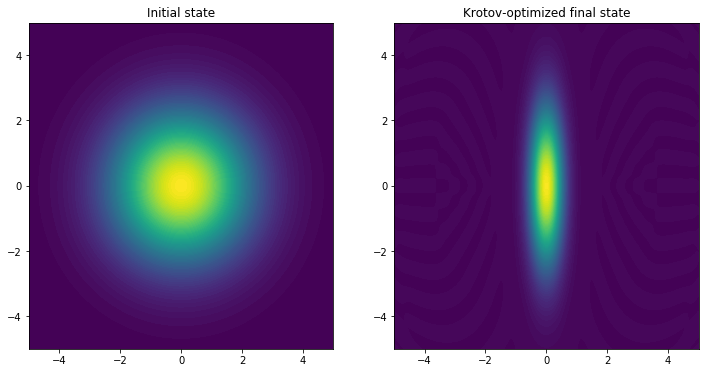

In [181]:
# store krotoov-optimized mechanical state in a contour plotting object
W_opt = qt.wigner(optimized_dynamics.states[-1].ptrace(1), xvec, xvec)

# plot the states
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
ax1.contourf(xvec, xvec, W_init, 100)
ax1.set_title("Initial state")
ax2.contourf(xvec, xvec, W_opt, 100)
ax2.set_title("Krotov-optimized final state")
plt.show()

# Plotting the squeezing parameters

## Re-run simulation and store expectatioon values

In [123]:
optimized_dynamics_expec = opt_result.optimized_objectives[0].mesolve(
    tlist2, e_ops=[proj0,proj1, proj2]
)

## Plot expectation values

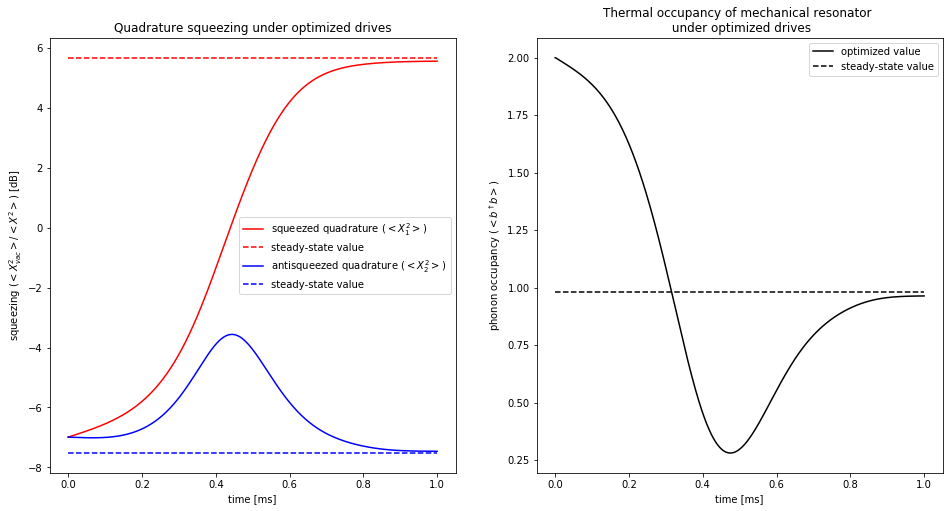

The first quadrature is squeezed by 5.56434 dB
The second quadrature is antisqueezed by 7.46375 dB


In [193]:
## plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,8))

# plot squeezed and antisqueezed quadratures
ax1.plot(
    tlist2 * 1000,
    quad2_dB(optimized_dynamics_expec.expect[0], Nb),
    label=r'squeezed quadrature ($<X_1^2>$)',
    color = 'red'
)
ax1.plot(
    tlist2 * 1000,
    quad2_dB(guess_dynamics.expect[0][-1]*np.ones_like(tlist2), Nb),
    label=r'steady-state value',
    color = 'red',
    linestyle = '--'
)
ax1.plot(
    tlist2 * 1000,
    quad2_dB(optimized_dynamics_expec.expect[1], Nb),
    label=r'antisqueezed quadrature ($<X_2^2>$)',
    color = 'blue'
)
ax1.plot(
    tlist2 * 1000,
    quad2_dB(guess_dynamics.expect[1][-1]*np.ones_like(tlist2), Nb),
    label=r'steady-state value',
    color = 'blue',
    linestyle = '--'
)
ax1.legend()
ax1.set_xlabel('time [ms]')
ax1.set_ylabel(r'squeezing ($<X_{vac}^2>/<X^2>$) [dB]')
ax1.set_title('Quadrature squeezing under optimized drives')

# plot mechanical phonon number
ax2.plot(
    tlist2 * 1000,
    optimized_dynamics_expec.expect[2],
    label=r'optimized value',
    color = 'black',
)
ax2.plot(
    tlist2 * 1000,
    guess_dynamics.expect[2][-1]*np.ones_like(tlist2),
    label='steady-state value',
    color = 'black',
    linestyle = '--'
)
ax2.legend()
ax2.set_xlabel('time [ms]')
ax2.set_ylabel(r'phonon occupancy ($<b^\dagger b>$)')
ax2.set_title('Thermal occupancy of mechanical resonator \n under optimized drives')

plt.show()

## print optimized quadtraure squeezing value
print('The first quadrature is squeezed by %g dB' % quad2_dB(optimized_dynamics_expec.expect[0], Nb)[-1])
print('The second quadrature is antisqueezed by %g dB' % -quad2_dB(optimized_dynamics_expec.expect[1], Nb)[-1])

Next: 60 iterations and adaptive lambda